March Madness ML Project

In [102]:
# lib imports copied from lab 4
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
sns.set()

In [103]:
# warnings are annoying to look at. Let's ignore them.
import warnings
warnings.filterwarnings('ignore')


# configures numerical displays to two decimal points
pd.options.display.float_format = '{:,.2f}'.format


In [104]:
# Datasets for initial exploration
Seeds = "mens-march-mania-2022\MDataFiles_Stage1\MNCAATourneySeeds.csv"
RSCR = "mens-march-mania-2022\MDataFiles_Stage1\MRegularSeasonCompactResults.csv"


# Remove cells that have no data
Seeds = pd.read_csv(Seeds, na_values = ["?"]).dropna()
RSCR = pd.read_csv(RSCR, na_values = ['?']).dropna()


# Due to player turn over we want to limit the data to "more recent" data of 2015 and onward and reset the index
RSCR = RSCR[(RSCR['Season'] >= 2015)].reset_index()
Seeds = Seeds[(Seeds['Season'] > 2015)].reset_index()


# Drop useless info
RSCR.drop(['NumOT', 'DayNum'], axis=1, inplace=True)
Seeds.drop(['index'], axis= 1, inplace= True)


# Need to replace the winning team location with numerical values
# Home game = 0, away game = 1, neutral court = 2 
RSCR['WLoc'].replace({'H' : 0, 'A' : 1, 'N' : 2}, inplace = True)


# Column indicating the loosing teams location
RSCR['LLoc'] = RSCR['WLoc']
RSCR['LLoc'].replace({0 : 1, 1 : 0}, inplace = True)

In [105]:
# Create a new column with the difference in points between winning and loosing team
RSCR['WinMargin'] = RSCR['WScore'] - RSCR['LScore']
RSCR.head()

,index,Season,WTeamID,WScore,LTeamID,LScore,WLoc,LLoc,WinMargin
0,134566,2015,1103,74,1420,57,0,1,17
1,134567,2015,1104,82,1406,54,0,1,28
2,134568,2015,1112,78,1291,55,0,1,23
3,134569,2015,1113,86,1152,50,0,1,36
4,134570,2015,1119,84,1102,78,0,1,6


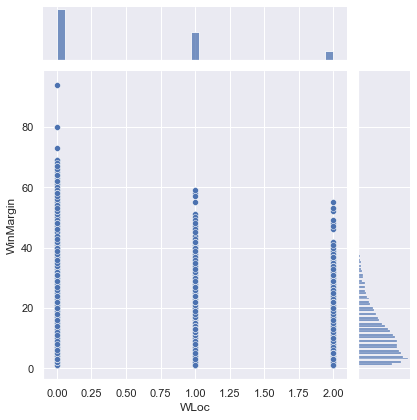

In [106]:
# Breif data exploration
sns.jointplot(x='WLoc',y='WinMargin',data=RSCR)

In [107]:
# Creating a shell dataframe to hold future stats of winning teams
winners = RSCR.groupby(['Season', 'WTeamID']).count().reset_index()
winners = winners[['Season', 'WTeamID']].rename(columns={'WTeamID': "TeamID"})
winners.head()


,Season,TeamID
0,2015,1101
1,2015,1102
2,2015,1103
3,2015,1104
4,2015,1105


In [108]:
# Creating a shell dataframe to hold future stats of loosing teams
lossers = RSCR.groupby(['Season', 'LTeamID']).count().reset_index()
lossers = lossers[['Season', 'LTeamID']].rename(columns={'LTeamID': "TeamID"})
lossers.head()

,Season,TeamID
0,2015,1101
1,2015,1102
2,2015,1103
3,2015,1104
4,2015,1105


In [109]:
# Concatinate the shell datasets to make sure we haven't missed any team IDs
team_stats = pd.concat([winners, lossers], axis = 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop = True)
team_stats.head()

,Season,TeamID
0,2015,1101
1,2015,1102
2,2015,1103
3,2015,1104
4,2015,1105


In [110]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2815 entries, 0 to 2814
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Season  2815 non-null   int64
 1   TeamID  2815 non-null   int64
dtypes: int64(2)
memory usage: 44.1 KB


In [111]:

# Creating team features based on aggregated data from each season
winner_team_stats = RSCR.groupby(['Season', 'WTeamID']).agg(TotalWins     = ('WTeamID', 'count'), 
                                                            AvgWinMargin  = ('WinMargin', 'mean'),
                                                            W_TotalPoints = ('WScore', 'sum'),
                                                            W_MaxPoints   = ('WScore', 'max'),
                                                            W_MinPoints   = ('WScore', 'min')
                                                            )
winner_team_stats = winner_team_stats.reset_index().rename(columns={"WTeamID": "TeamID"})
winner_team_stats.head()

,Season,TeamID,TotalWins,AvgWinMargin,W_TotalPoints,W_MaxPoints,W_MinPoints
0,2015,1101,7,12.14,542,95,65
1,2015,1102,12,13.67,839,80,53
2,2015,1103,20,11.90,1396,82,53
3,2015,1104,17,10.35,1152,82,55
4,2015,1105,8,9.00,579,86,51


In [112]:
# Check for null values
winner_team_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2809 entries, 0 to 2808
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Season         2809 non-null   int64  
 1   TeamID         2809 non-null   int64  
 2   TotalWins      2809 non-null   int64  
 3   AvgWinMargin   2809 non-null   float64
 4   W_TotalPoints  2809 non-null   int64  
 5   W_MaxPoints    2809 non-null   int64  
 6   W_MinPoints    2809 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 153.7 KB


In [113]:
# Creating team features based on aggregated data from each season
losser_team_stats = RSCR.groupby(['Season', 'LTeamID']).agg(TotalLosses     = ('LTeamID', 'count'), 
                                                            AvgLossMargin  = ('WinMargin', 'mean'),
                                                            L_TotalPoints = ('LScore', 'sum'),
                                                            L_MaxPoints   = ('LScore', 'max'),
                                                            L_MinPoints   = ('LScore', 'min')
                                                            )
losser_team_stats = losser_team_stats.reset_index().rename(columns={"LTeamID": "TeamID"})
losser_team_stats.head()

,Season,TeamID,TotalLosses,AvgLossMargin,L_TotalPoints,L_MaxPoints,L_MinPoints
0,2015,1101,21,18.52,1166,81,27
1,2015,1102,17,11.59,1038,87,42
2,2015,1103,14,7.00,894,82,46
3,2015,1104,14,7.86,914,91,48
4,2015,1105,20,14.00,1137,75,39


In [114]:
# Check for any null values
losser_team_stats.isnull().sum()

Season           0
TeamID           0
TotalLosses      0
AvgLossMargin    0
L_TotalPoints    0
L_MaxPoints      0
L_MinPoints      0
dtype: int64

In [115]:
# Merge winning and loosing team data into the shell dataframe for consolidation
team_stats = team_stats.merge(winner_team_stats, on = ['Season', 'TeamID'], how = 'left')
team_stats = team_stats.merge(losser_team_stats, on = ['Season', 'TeamID'], how = 'left')

# This is needed to account for the rare teams that dont loose in the regular season, without it there are 'NaN' in the data that causes problems
team_stats.fillna(0, inplace=True)

In [116]:
team_stats.isnull().sum()

Season           0
TeamID           0
TotalWins        0
AvgWinMargin     0
W_TotalPoints    0
W_MaxPoints      0
W_MinPoints      0
TotalLosses      0
AvgLossMargin    0
L_TotalPoints    0
L_MaxPoints      0
L_MinPoints      0
dtype: int64

In [117]:
team_stats

,Season,TeamID,TotalWins,AvgWinMargin,W_TotalPoints,W_MaxPoints,W_MinPoints,TotalLosses,AvgLossMargin,L_TotalPoints,L_MaxPoints,L_MinPoints
0,2015,1101,7.00,12.14,542.00,95.00,65.00,21.00,18.52,"1,166.00",81.00,27.00
1,2015,1102,12.00,13.67,839.00,80.00,53.00,17.00,11.59,"1,038.00",87.00,42.00
2,2015,1103,20.00,11.90,"1,396.00",82.00,53.00,14.00,7.00,894.00,82.00,46.00
3,2015,1104,17.00,10.35,"1,152.00",82.00,55.00,14.00,7.86,914.00,91.00,48.00
4,2015,1105,8.00,9.00,579.00,86.00,51.00,20.00,14.00,"1,137.00",75.00,39.00
...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2022,1468,9.00,10.67,671.00,85.00,66.00,11.00,16.55,661.00,70.00,50.00
2811,2022,1469,7.00,11.43,557.00,85.00,71.00,12.00,19.33,764.00,73.00,50.00
2812,2022,1470,8.00,11.12,565.00,83.00,57.00,13.00,11.77,767.00,84.00,50.00
2813,2022,1471,8.00,10.12,632.00,85.00,71.00,12.00,13.42,710.00,80.00,48.00


In [118]:
# Create custom statistics that condense team information contained in the raw data
# WinRatio = how often a team wins
# AvgScoreMargin = the average amount of points a team is away from their opponents score 
# PointsRatio = the percent of total points a team scored that contributed to a winning game
team_stats['WinRatio'] = team_stats['TotalWins'] / (team_stats['TotalWins'] + team_stats['TotalLosses'])
team_stats['AvgScoreMargin'] = ((team_stats['TotalWins'] * team_stats['AvgWinMargin'] - team_stats['TotalLosses'] * team_stats['AvgLossMargin']) / (team_stats['TotalWins'] + team_stats['TotalLosses']))
team_stats['PointsRatio'] = team_stats['W_TotalPoints'] / (team_stats['L_TotalPoints'] + team_stats['W_TotalPoints'])

team_stats


,Season,TeamID,TotalWins,AvgWinMargin,W_TotalPoints,W_MaxPoints,W_MinPoints,TotalLosses,AvgLossMargin,L_TotalPoints,L_MaxPoints,L_MinPoints,WinRatio,AvgScoreMargin,PointsRatio
0,2015,1101,7.00,12.14,542.00,95.00,65.00,21.00,18.52,"1,166.00",81.00,27.00,0.25,-10.86,0.32
1,2015,1102,12.00,13.67,839.00,80.00,53.00,17.00,11.59,"1,038.00",87.00,42.00,0.41,-1.14,0.45
2,2015,1103,20.00,11.90,"1,396.00",82.00,53.00,14.00,7.00,894.00,82.00,46.00,0.59,4.12,0.61
3,2015,1104,17.00,10.35,"1,152.00",82.00,55.00,14.00,7.86,914.00,91.00,48.00,0.55,2.13,0.56
4,2015,1105,8.00,9.00,579.00,86.00,51.00,20.00,14.00,"1,137.00",75.00,39.00,0.29,-7.43,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,2022,1468,9.00,10.67,671.00,85.00,66.00,11.00,16.55,661.00,70.00,50.00,0.45,-4.30,0.50
2811,2022,1469,7.00,11.43,557.00,85.00,71.00,12.00,19.33,764.00,73.00,50.00,0.37,-8.00,0.42
2812,2022,1470,8.00,11.12,565.00,83.00,57.00,13.00,11.77,767.00,84.00,50.00,0.38,-3.05,0.42
2813,2022,1471,8.00,10.12,632.00,85.00,71.00,12.00,13.42,710.00,80.00,48.00,0.40,-4.00,0.47


In [119]:
# Reduce the dataframe from raw team data to the custom team statistics
team_stats = team_stats[['Season', 'TeamID', 'WinRatio', 'AvgScoreMargin', 'PointsRatio']]
team_stats

,Season,TeamID,WinRatio,AvgScoreMargin,PointsRatio
0,2015,1101,0.25,-10.86,0.32
1,2015,1102,0.41,-1.14,0.45
2,2015,1103,0.59,4.12,0.61
3,2015,1104,0.55,2.13,0.56
4,2015,1105,0.29,-7.43,0.34
...,...,...,...,...,...
2810,2022,1468,0.45,-4.30,0.50
2811,2022,1469,0.37,-8.00,0.42
2812,2022,1470,0.38,-3.05,0.42
2813,2022,1471,0.40,-4.00,0.47


In [120]:
team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2815 entries, 0 to 2814
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          2815 non-null   int64  
 1   TeamID          2815 non-null   int64  
 2   WinRatio        2815 non-null   float64
 3   AvgScoreMargin  2815 non-null   float64
 4   PointsRatio     2815 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 132.0 KB


Training Dataset

In [121]:
seed_data = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySeeds.csv')
tourney_data = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
tourney_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [122]:
# Make columns easier to read/interpret
tourney_data = tourney_data.rename(columns = {'WTeamID' : 'W_TeamID', 'LTeamID' : 'L_TeamID', 'WScore' : 'W_Score', 'LScore' : 'L_Score'})  

In [123]:
# Drop unimportant features from the dataset
tourney_data.drop(['NumOT', 'WLoc', 'DayNum'], axis = 1, inplace = True)


# Reduce data to 2015 season and later 
tourney_data = tourney_data[tourney_data['Season'] >= 2015].reset_index(drop = True)

In [124]:
tourney_data.head()

,Season,W_TeamID,W_Score,L_TeamID,L_Score
0,2015,1214,74,1264,64
1,2015,1279,94,1140,90
2,2015,1173,56,1129,55
3,2015,1352,81,1316,77
4,2015,1112,93,1411,72


In [125]:
# Combine seed data with team IDs and win/loss scores
tourney_data = pd.merge(tourney_data,seed_data, how = 'left', left_on = ['Season', 'W_TeamID'], right_on = ['Season', 'TeamID'])
tourney_data = tourney_data.drop('TeamID', axis = 1).rename(columns = {'Seed': 'W_Seed'})

tourney_data = pd.merge(tourney_data,seed_data, how = 'left', left_on = ['Season', 'L_TeamID'], right_on = ['Season', 'TeamID'])
tourney_data = tourney_data.drop('TeamID', axis = 1).rename(columns = {'Seed': 'L_Seed'})

In [126]:
tourney_data

,Season,W_TeamID,W_Score,L_TeamID,L_Score,W_Seed,L_Seed
0,2015,1214,74,1264,64,Y16a,Y16b
1,2015,1279,94,1140,90,Z11b,Z11a
2,2015,1173,56,1129,55,W11b,W11a
3,2015,1352,81,1316,77,X16b,X16a
4,2015,1112,93,1411,72,Z02,Z15
...,...,...,...,...,...,...,...
396,2021,1211,85,1425,66,X01,X06
397,2021,1417,51,1276,49,W11b,W01
398,2021,1124,78,1222,59,Z01,Y02
399,2021,1211,93,1417,90,X01,W11b


In [127]:
# We only care about the numerical information pertaining to seed data. Remove string values.
tourney_data['W_Seed'] = tourney_data['W_Seed'].astype('str').str.extractall('(\d+)').unstack().astype(int)
tourney_data['L_Seed'] = tourney_data['L_Seed'].astype('str').str.extractall('(\d+)').unstack().astype(int)
tourney_data

,Season,W_TeamID,W_Score,L_TeamID,L_Score,W_Seed,L_Seed
0,2015,1214,74,1264,64,16,16
1,2015,1279,94,1140,90,11,11
2,2015,1173,56,1129,55,11,11
3,2015,1352,81,1316,77,16,16
4,2015,1112,93,1411,72,2,15
...,...,...,...,...,...,...,...
396,2021,1211,85,1425,66,1,6
397,2021,1417,51,1276,49,11,1
398,2021,1124,78,1222,59,1,2
399,2021,1211,93,1417,90,1,11


In [128]:
# Combines the winning/lossing team statistics with the team seed data
for result in ['W', 'L']:
    tourney_data = pd.merge(tourney_data, team_stats, how = 'left', left_on = ['Season', result +'_'+ 'TeamID'], right_on = ['Season', 'TeamID'])
    avoid = ['Season', 'TeamID']
    new_names = {col: result +'_'+ col for col in team_stats.columns if col not in avoid}
    tourney_data = tourney_data.rename(columns = new_names)        
    tourney_data = tourney_data.drop(columns = 'TeamID', axis = 1)

In [129]:
tourney_data

,Season,W_TeamID,W_Score,L_TeamID,L_Score,W_Seed,L_Seed,W_WinRatio,W_AvgScoreMargin,W_PointsRatio,L_WinRatio,L_AvgScoreMargin,L_PointsRatio
0,2015,1214,74,1264,64,16,16,0.48,-0.85,0.53,0.59,2.38,0.63
1,2015,1279,94,1140,90,11,11,0.62,5.12,0.64,0.72,8.91,0.74
2,2015,1173,56,1129,55,11,11,0.76,7.30,0.78,0.74,8.94,0.79
3,2015,1352,81,1316,77,16,16,0.58,1.27,0.62,0.65,5.42,0.68
4,2015,1112,93,1411,72,2,15,0.91,17.82,0.92,0.65,0.74,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2021,1211,85,1425,66,1,6,1.00,23.00,1.00,0.76,9.66,0.80
397,2021,1417,51,1276,49,11,1,0.65,4.35,0.68,0.83,10.88,0.87
398,2021,1124,78,1222,59,1,2,0.92,17.96,0.93,0.88,18.00,0.90
399,2021,1211,93,1417,90,1,11,1.00,23.00,1.00,0.65,4.35,0.68


In [130]:
tourney_data_Win = tourney_data.copy()
tourney_data_Loser = tourney_data.copy()

# Changes the winning and losing team identifiers with a more ambiguous A and B
tourney_data_Win.rename(columns={"W_TeamID": "A_TeamID"}, inplace= True)
tourney_data_Win.rename(columns={"L_TeamID": "B_TeamID"}, inplace= True)
tourney_data_Win.rename(columns={"W_Score": "A_Score"}, inplace= True)
tourney_data_Win.rename(columns={"L_Score": "B_Score"}, inplace= True)
tourney_data_Win.rename(columns={"W_Seed": "A_Seed"}, inplace= True)
tourney_data_Win.rename(columns={"L_Seed": "B_Seed"}, inplace= True)
tourney_data_Win.rename(columns={"W_WinRatio": "A_WinRatio"}, inplace= True)
tourney_data_Win.rename(columns={"L_WinRatio": "B_WinRatio"}, inplace= True)
tourney_data_Win.rename(columns={"W_AvgScoreMargin": "A_AvgScoreMargin"}, inplace= True)
tourney_data_Win.rename(columns={"L_AvgScoreMargin": "B_AvgScoreMargin"}, inplace= True)
tourney_data_Win.rename(columns={"W_PointsRatio": "A_PointsRatio"}, inplace= True)
tourney_data_Win.rename(columns={"L_PointsRatio": "B_PointsRatio"}, inplace= True)

# Same as above but switches the assignment allocation
tourney_data_Loser.rename(columns={"W_TeamID": "B_TeamID"}, inplace= True)
tourney_data_Loser.rename(columns={"L_TeamID": "A_TeamID"}, inplace= True)
tourney_data_Loser.rename(columns={"W_Score": "B_Score"}, inplace= True)
tourney_data_Loser.rename(columns={"L_Score": "A_Score"}, inplace= True)
tourney_data_Loser.rename(columns={"W_Seed": "B_Seed"}, inplace= True)
tourney_data_Loser.rename(columns={"L_Seed": "A_Seed"}, inplace= True)
tourney_data_Loser.rename(columns={"W_WinRatio": "B_WinRatio"}, inplace= True)
tourney_data_Loser.rename(columns={"L_WinRatio": "A_WinRatio"}, inplace= True)
tourney_data_Loser.rename(columns={"W_AvgScoreMargin": "B_AvgScoreMargin"}, inplace= True)
tourney_data_Loser.rename(columns={"L_AvgScoreMargin": "A_AvgScoreMargin"}, inplace= True)
tourney_data_Loser.rename(columns={"W_PointsRatio": "B_PointsRatio"}, inplace= True)
tourney_data_Loser.rename(columns={"L_PointsRatio": "A_PointsRatio"}, inplace= True)

# Combine the two sets of data to account for every teams win and lose statistics
tourney_data = pd.concat([tourney_data_Win, tourney_data_Loser], axis= 0, sort= True)
tourney_data = tourney_data.reindex(columns= ['Season', 'A_TeamID', 'A_Score', 'B_TeamID', 'B_Score', 'A_Seed', 'B_Seed','A_WinRatio','A_AvgScoreMargin', 'A_PointsRatio','B_WinRatio','B_AvgScoreMargin', 'B_PointsRatio'])
tourney_data.reset_index(drop = True)

tourney_data

,Season,A_TeamID,A_Score,B_TeamID,B_Score,A_Seed,B_Seed,A_WinRatio,A_AvgScoreMargin,A_PointsRatio,B_WinRatio,B_AvgScoreMargin,B_PointsRatio
0,2015,1214,74,1264,64,16,16,0.48,-0.85,0.53,0.59,2.38,0.63
1,2015,1279,94,1140,90,11,11,0.62,5.12,0.64,0.72,8.91,0.74
2,2015,1173,56,1129,55,11,11,0.76,7.30,0.78,0.74,8.94,0.79
3,2015,1352,81,1316,77,16,16,0.58,1.27,0.62,0.65,5.42,0.68
4,2015,1112,93,1411,72,2,15,0.91,17.82,0.92,0.65,0.74,0.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2021,1425,66,1211,85,6,1,0.76,9.66,0.80,1.00,23.00,1.00
397,2021,1276,49,1417,51,1,11,0.83,10.88,0.87,0.65,4.35,0.68
398,2021,1222,59,1124,78,2,1,0.88,18.00,0.90,0.92,17.96,0.93
399,2021,1417,90,1211,93,11,1,0.65,4.35,0.68,1.00,23.00,1.00


In [131]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 400
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Season            802 non-null    int64  
 1   A_TeamID          802 non-null    int64  
 2   A_Score           802 non-null    int64  
 3   B_TeamID          802 non-null    int64  
 4   B_Score           802 non-null    int64  
 5   A_Seed            802 non-null    int32  
 6   B_Seed            802 non-null    int32  
 7   A_WinRatio        802 non-null    float64
 8   A_AvgScoreMargin  802 non-null    float64
 9   A_PointsRatio     802 non-null    float64
 10  B_WinRatio        802 non-null    float64
 11  B_AvgScoreMargin  802 non-null    float64
 12  B_PointsRatio     802 non-null    float64
dtypes: float64(6), int32(2), int64(5)
memory usage: 81.5 KB


In [132]:
# More custom statistics
tourney_data['SeedDiff'] = tourney_data['A_Seed'] - tourney_data['B_Seed']
tourney_data['WinRatioDiff'] = tourney_data['A_WinRatio'] - tourney_data['B_WinRatio']
tourney_data['AvgScoreMarginDiff'] = tourney_data['A_AvgScoreMargin'] - tourney_data['B_AvgScoreMargin']
tourney_data['PointsRatioDiff'] = tourney_data['A_PointsRatio'] - tourney_data['B_PointsRatio']
tourney_data['ScoreMargin'] = tourney_data['A_Score'] - tourney_data['B_Score']

# This is our output variable to compare our model resutls with
tourney_data['A_Wins'] = (tourney_data['ScoreMargin'] > 0).astype(int)
tourney_data = tourney_data.drop(columns= ['A_Score', 'B_Score'])

tourney_data

,Season,A_TeamID,B_TeamID,A_Seed,B_Seed,A_WinRatio,A_AvgScoreMargin,A_PointsRatio,B_WinRatio,B_AvgScoreMargin,B_PointsRatio,SeedDiff,WinRatioDiff,AvgScoreMarginDiff,PointsRatioDiff,ScoreMargin,A_Wins
0,2015,1214,1264,16,16,0.48,-0.85,0.53,0.59,2.38,0.63,0,-0.11,-3.22,-0.10,10,1
1,2015,1279,1140,11,11,0.62,5.12,0.64,0.72,8.91,0.74,0,-0.09,-3.78,-0.10,4,1
2,2015,1173,1129,11,11,0.76,7.30,0.78,0.74,8.94,0.79,0,0.02,-1.63,-0.01,1,1
3,2015,1352,1316,16,16,0.58,1.27,0.62,0.65,5.42,0.68,0,-0.07,-4.15,-0.06,4,1
4,2015,1112,1411,2,15,0.91,17.82,0.92,0.65,0.74,0.70,-13,0.26,17.09,0.22,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2021,1425,1211,6,1,0.76,9.66,0.80,1.00,23.00,1.00,5,-0.24,-13.34,-0.20,-19,0
397,2021,1276,1417,1,11,0.83,10.88,0.87,0.65,4.35,0.68,-10,0.18,6.53,0.18,-2,0
398,2021,1222,1124,2,1,0.88,18.00,0.90,0.92,17.96,0.93,1,-0.03,0.04,-0.04,-19,0
399,2021,1417,1211,11,1,0.65,4.35,0.68,1.00,23.00,1.00,10,-0.35,-18.65,-0.32,-3,0


In [133]:
tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 400
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Season              802 non-null    int64  
 1   A_TeamID            802 non-null    int64  
 2   B_TeamID            802 non-null    int64  
 3   A_Seed              802 non-null    int32  
 4   B_Seed              802 non-null    int32  
 5   A_WinRatio          802 non-null    float64
 6   A_AvgScoreMargin    802 non-null    float64
 7   A_PointsRatio       802 non-null    float64
 8   B_WinRatio          802 non-null    float64
 9   B_AvgScoreMargin    802 non-null    float64
 10  B_PointsRatio       802 non-null    float64
 11  SeedDiff            802 non-null    int32  
 12  WinRatioDiff        802 non-null    float64
 13  AvgScoreMarginDiff  802 non-null    float64
 14  PointsRatioDiff     802 non-null    float64
 15  ScoreMargin         802 non-null    int64  
 16  A_Wins  

Test Data

In [134]:
kggl_submission_tmplt = pd.read_csv('mens-march-mania-2022\MDataFiles_Stage1\MSampleSubmissionStage1.csv')
test_data = kggl_submission_tmplt.copy()

In [135]:
test_data

,ID,Pred
0,2016_1112_1114,0.50
1,2016_1112_1122,0.50
2,2016_1112_1124,0.50
3,2016_1112_1138,0.50
4,2016_1112_1139,0.50
...,...,...
11385,2021_1452_1457,0.50
11386,2021_1452_1458,0.50
11387,2021_1455_1457,0.50
11388,2021_1455_1458,0.50


In [136]:
#need to split the ID into Year and Team ID's
new =test_data['ID'].str.split('_', n= 3, expand= True).astype(int)

test_data['Season'] = new[0]
test_data['A_TeamID'] = new[1]
test_data['B_TeamID'] = new[2]

test_data

,ID,Pred,Season,A_TeamID,B_TeamID
0,2016_1112_1114,0.50,2016,1112,1114
1,2016_1112_1122,0.50,2016,1112,1122
2,2016_1112_1124,0.50,2016,1112,1124
3,2016_1112_1138,0.50,2016,1112,1138
4,2016_1112_1139,0.50,2016,1112,1139
...,...,...,...,...,...
11385,2021_1452_1457,0.50,2021,1452,1457
11386,2021_1452_1458,0.50,2021,1452,1458
11387,2021_1455_1457,0.50,2021,1455,1457
11388,2021_1455_1458,0.50,2021,1455,1458


In [137]:
# Same process as training data
test_data = pd.merge(test_data, Seeds, how = 'left', left_on = ['Season', 'A_TeamID'], right_on = ['Season', 'TeamID'])
test_data = test_data.drop('TeamID', axis = 1).rename(columns = {'Seed': 'A_Seed'})

test_data = pd.merge(test_data, Seeds, how = 'left', left_on = ['Season', 'B_TeamID'], right_on = ['Season', 'TeamID'])
test_data = test_data.drop('TeamID', axis = 1).rename(columns = {'Seed': 'B_Seed'})

test_data['A_Seed'] = test_data['A_Seed'].astype('str').str.extractall('(\d+)').unstack().astype(int)
test_data['B_Seed'] = test_data['B_Seed'].astype('str').str.extractall('(\d+)').unstack().astype(int)

test_data

,ID,Pred,Season,A_TeamID,B_TeamID,A_Seed,B_Seed
0,2016_1112_1114,0.50,2016,1112,1114,6,12
1,2016_1112_1122,0.50,2016,1112,1122,6,16
2,2016_1112_1124,0.50,2016,1112,1124,6,5
3,2016_1112_1138,0.50,2016,1112,1138,6,14
4,2016_1112_1139,0.50,2016,1112,1139,6,9
...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.50,2021,1452,1457,3,12
11386,2021_1452_1458,0.50,2021,1452,1458,3,9
11387,2021_1455_1457,0.50,2021,1455,1457,11,12
11388,2021_1455_1458,0.50,2021,1455,1458,11,9


In [138]:
for result in ['A', 'B']:
    test_data = pd.merge(test_data, team_stats, how = 'left', left_on = ['Season', result +'_'+ 'TeamID'], right_on = ['Season', 'TeamID'])
    avoid = ['Season', 'TeamID']
    new_names = {col: result +'_'+ col for col in team_stats.columns if col not in avoid}
    test_data = test_data.rename(columns = new_names)        
    test_data = test_data.drop(columns = 'TeamID', axis = 1)

test_data    

,ID,Pred,Season,A_TeamID,B_TeamID,A_Seed,B_Seed,A_WinRatio,A_AvgScoreMargin,A_PointsRatio,B_WinRatio,B_AvgScoreMargin,B_PointsRatio
0,2016_1112_1114,0.50,2016,1112,1114,6,12,0.76,12.21,0.77,0.87,9.94,0.88
1,2016_1112_1122,0.50,2016,1112,1122,6,16,0.76,12.21,0.77,0.48,-2.36,0.54
2,2016_1112_1124,0.50,2016,1112,1124,6,5,0.76,12.21,0.77,0.66,6.69,0.70
3,2016_1112_1138,0.50,2016,1112,1138,6,14,0.76,12.21,0.77,0.58,0.67,0.62
4,2016_1112_1139,0.50,2016,1112,1139,6,9,0.76,12.21,0.77,0.68,9.42,0.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.50,2021,1452,1457,3,12,0.67,5.19,0.67,0.96,12.75,0.97
11386,2021_1452_1458,0.50,2021,1452,1458,3,9,0.67,5.19,0.67,0.59,5.31,0.62
11387,2021_1455_1457,0.50,2021,1455,1457,11,12,0.74,2.63,0.78,0.96,12.75,0.97
11388,2021_1455_1458,0.50,2021,1455,1458,11,9,0.74,2.63,0.78,0.59,5.31,0.62


In [139]:
test_data['SeedDiff'] = test_data['A_Seed'] - test_data['B_Seed']
test_data['WinRatioDiff'] = test_data['A_WinRatio'] - test_data['B_WinRatio']
test_data['AvgScoreMarginDiff'] = test_data['A_AvgScoreMargin'] - test_data['B_AvgScoreMargin']
test_data['PointsRatioDiff'] = test_data['A_PointsRatio'] - test_data['B_PointsRatio']

test_data

,ID,Pred,Season,A_TeamID,B_TeamID,A_Seed,B_Seed,A_WinRatio,A_AvgScoreMargin,A_PointsRatio,B_WinRatio,B_AvgScoreMargin,B_PointsRatio,SeedDiff,WinRatioDiff,AvgScoreMarginDiff,PointsRatioDiff
0,2016_1112_1114,0.50,2016,1112,1114,6,12,0.76,12.21,0.77,0.87,9.94,0.88,-6,-0.11,2.28,-0.11
1,2016_1112_1122,0.50,2016,1112,1122,6,16,0.76,12.21,0.77,0.48,-2.36,0.54,-10,0.27,14.58,0.23
2,2016_1112_1124,0.50,2016,1112,1124,6,5,0.76,12.21,0.77,0.66,6.69,0.70,1,0.10,5.52,0.06
3,2016_1112_1138,0.50,2016,1112,1138,6,14,0.76,12.21,0.77,0.58,0.67,0.62,-8,0.18,11.55,0.14
4,2016_1112_1139,0.50,2016,1112,1139,6,9,0.76,12.21,0.77,0.68,9.42,0.74,-3,0.08,2.79,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2021_1452_1457,0.50,2021,1452,1457,3,12,0.67,5.19,0.67,0.96,12.75,0.97,-9,-0.29,-7.56,-0.30
11386,2021_1452_1458,0.50,2021,1452,1458,3,9,0.67,5.19,0.67,0.59,5.31,0.62,-6,0.08,-0.13,0.05
11387,2021_1455_1457,0.50,2021,1455,1457,11,12,0.74,2.63,0.78,0.96,12.75,0.97,-1,-0.22,-10.12,-0.19
11388,2021_1455_1458,0.50,2021,1455,1458,11,9,0.74,2.63,0.78,0.59,5.31,0.62,2,0.15,-2.68,0.16


In [140]:
# Removing all season data before 2021 could have been done much sooner but since the process was the same as the training data, leaving it in make it easy to validate procedural steps 
test_data = test_data[test_data['Season'] == 2021].reset_index(drop = True)

Time to start testing...

In [141]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

In [142]:
# Define predictors and output variable
target_feature = 'A_Wins'
avoid = ['ID', 'Pred', 'ScoreMargin', 'Season', 'A_Wins']
features = [col for col in tourney_data.columns if col not in avoid]

In [143]:
X_train = tourney_data[tourney_data['Season'] <= 2020][features].reset_index(drop = True).copy()
X_test = tourney_data[tourney_data['Season'] == 2021][features].reset_index(drop = True).copy()

y_train = tourney_data[tourney_data['Season'] <= 2020][target_feature].reset_index(drop = True).copy()
y_test = tourney_data[tourney_data['Season'] == 2021][target_feature].reset_index(drop = True).copy()

tst_dataset = test_data[features].copy()

# Create a scalar value to create consistency between predictor values 
scaler = MinMaxScaler()
scaler.fit(X_train)

# Scale all predictor values
X_train = scaler.transform(X_train)        
X_test = scaler.transform(X_test)
tst_dataset = scaler.transform(tst_dataset)

# Boosted random forest model. Estimators = # of boosting rounds, random_state = random seed val
model = XGBClassifier(n_estimators = 2048, random_state = 3)
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], verbose = 0, early_stopping_rounds = 128)
pred = model.predict_proba(X_test)[:, 1]

pred_test = model.predict_proba(tst_dataset)[:, 1]

[16:24:15] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [144]:
# Put model predictions into dataframe
csv = np.array(pred_test)
csv = csv.T
csv = pd.DataFrame (csv, columns = ['Pred'])

In [145]:
# Export predictions to csv file
results = test_data[['ID', 'Pred']].copy()
results['Pred'] = csv
results.to_csv('project_results.csv', index = False)